# Description

For defining functional groups and reaction mechanisms for polymerization

# Core Imports

In [1]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.amalgamation import portlib, bonding

from polymerist.monomers.substruct.functgroups import FN_GROUP_TABLE
from polymerist.monomers.substruct import specification


# File I/O
from pathlib import Path
import json

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH.mkdir(exist_ok=True)

/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist_env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Defining target functional groups

### Locate base SMARTS to build off of

hydroxyl [OX2H]


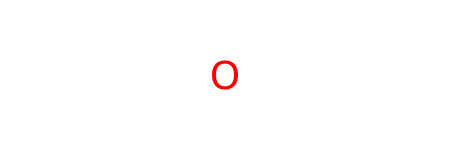

carboxyl [CX3](=O)[OX2H1]


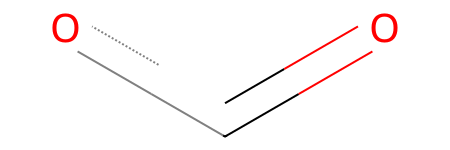

carbamate [NX3,NX4+][CX3](=[OX1])[OX2,OX1-]


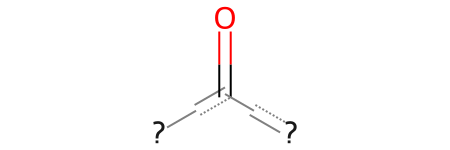

acyl_chloride [CX3](=[OX1])[F,Cl,Br,I]


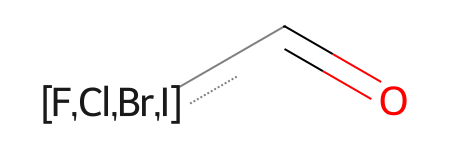

isocyanate [NX3][CX2]#[NX1]


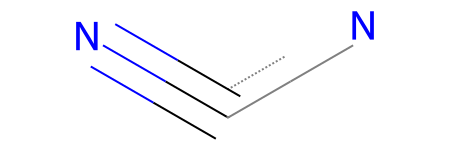

ester [#6][CX3](=O)[OX2H0][#6]


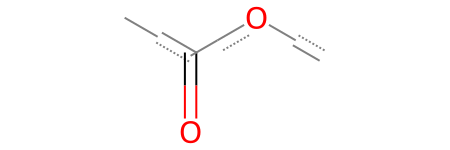

In [2]:
gb = FN_GROUP_TABLE.groupby('group_name')
smarts_keys = {
    'hydroxyl'      : ('Hydroxyl', 156),
    'carboxyl'      : ('Carboxylic acid', 51),
    'carbamate'     : ('Carbamate.', 46),
    'acyl_chloride' : ('Acyl Halide', 237),
    'isocyanate'    : ('Cyanamide', 54),
    'ester'         : ('Ester Also hits anhydrides', 58)
}

smarts_dict, mol_dict = {}, {}
for fn_group_name, (group_key, idx) in smarts_keys.items():
    smarts = gb.get_group(group_key).loc[idx].SMARTS
    rdmol = Chem.MolFromSmarts(smarts)

    print(fn_group_name, smarts)
    display(rdmol)

    smarts_dict[fn_group_name] = smarts 
    mol_dict[fn_group_name] = rdmol 

### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


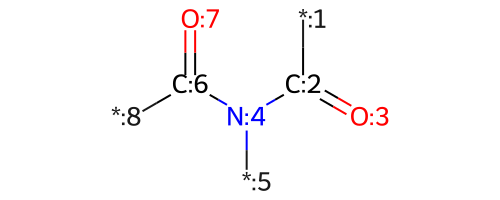

carbamate


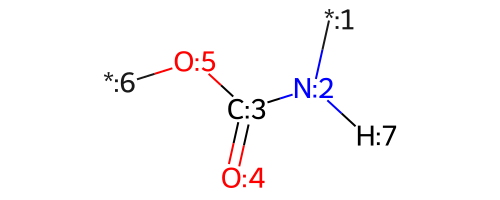

cyclocarbonate


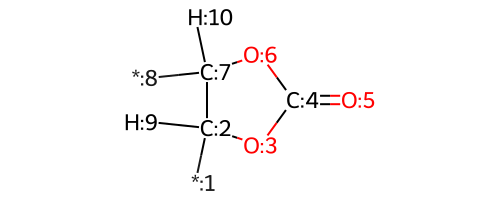

anhydride


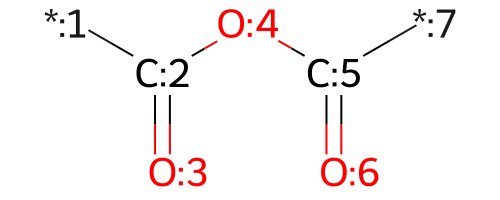

vinyl


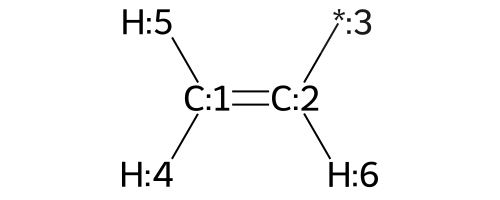

acyl_chloride


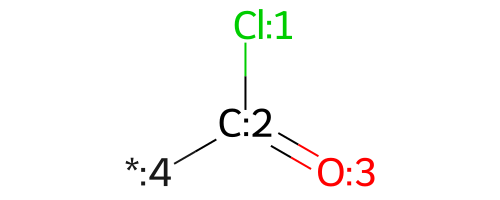

carboxyl


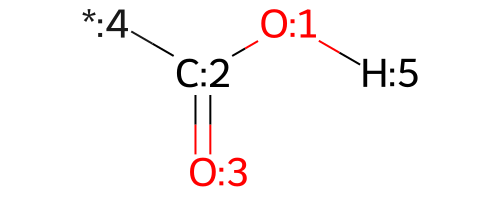

ester


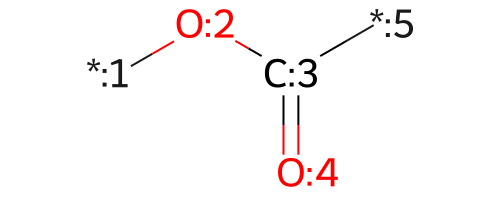

amine


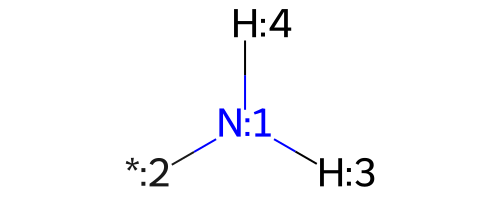

hydroxyl


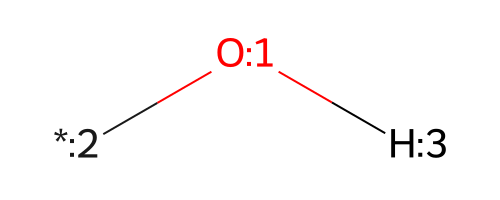

isocyanate


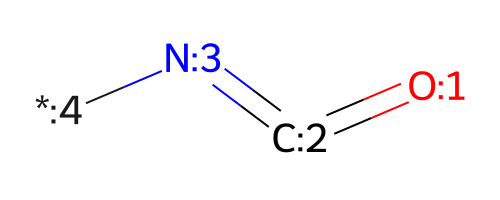

In [3]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smiles_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'   : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    'cyclocarbonate' : '*C1OC(=O)OC1*',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : 'C=C*',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_group_smiles, fn_groups = {}, {}
for group_name, smiles in fn_group_smiles_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=True)
    fn_group_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    for atom in fn_group_mol.GetAtoms():
        if portlib.is_linker(atom):
            atom.SetProp('molFileValue', group_name)
            break # ensure this is only set once
    
    print(group_name)
    display(fn_group_mol)

    fn_group_smiles[group_name] = exp_smiles
    fn_groups[      group_name] = fn_group_mol

with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smiles, file, indent=4)

### Define complete small-molecule byproducts (as query mols)

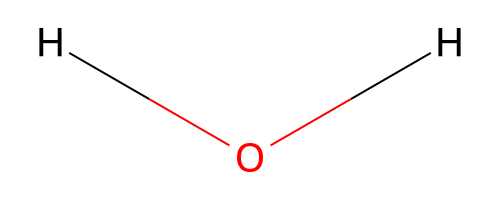

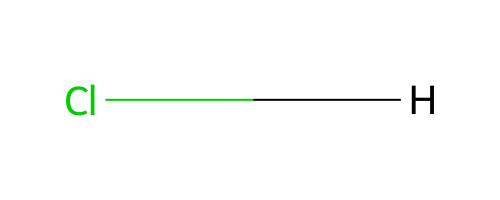

In [4]:
byproduct_smiles_bare = {
    'water' : 'O',
    'hcl'   : '[ClH]'
}

byproduct_smiles, byproducts = {}, {}
for group_name, smiles in byproduct_smiles_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=False)
    byproduct = Chem.MolFromSmarts(exp_smiles) # must be SMARTS for successful query

    byproduct_smiles[group_name] = exp_smiles
    byproducts[group_name] = byproduct
    display(byproduct)

# Defining polymerization reactions

In [5]:
from dataclasses import dataclass, field
from typing import Iterable, Optional, Union
from polymerist.rdutils.rdtypes import RDMol


@dataclass
class MechanismSchema:
    '''Encapsulates functional group and bond derangement info for a reaction mechanism'''
    reactive_groups  : Iterable[str]
    byproducts       : Iterable[RDMol] = field(default_factory=list)
    bond_derangement : dict[int, tuple[int, int]] = field(default_factory=dict)
    rxn_name : str = ''

    @property
    def reactants(self) -> RDMol:
        '''Combine cached reactive groups into single, contiguously-numbered Mol for manipulation'''
        # 1) extracting and labelling reactants
        reactants = molwise.assign_contiguous_atom_map_nums(*self.reactive_groups, in_place=False) # needed up-front to display reactants for derangement determination
        return Chem.CombineMols(*reactants) 

    def products(self, debug_display : bool=False) -> RDMol:
        '''Generate the product template defined by the provided reactants and bond derangement'''
        if not self.bond_derangement:
            raise ValueError('Must provide non-empty bond derangement')

        # 2) defining and swapping bonds to form product
        products = bonding.swap_bonds(Chem.RWMol(self.reactants), self.bond_derangement, debug_display=debug_display) # create editable Mol
        Chem.SanitizeMol(products, sanitizeOps=specification.SANITIZE_AS_KEKULE)

        return products
    
    def products_by_importance(self, combined : bool=True) -> tuple[Union[Optional[RDMol], list[RDMol]], Union[Optional[RDMol], list[RDMol]]]:
        '''Partition reaction products into major and minor/byproducts, each returned as a single Combined Mol'''
        product_partition = main_products, byproducts = [], []
        for product in Chem.GetMolFrags(self.products(debug_display=False), asMols=True):
            for side_query_mol in self.byproducts:
                if product.HasSubstructMatch(side_query_mol) and (product.GetNumAtoms() == side_query_mol.GetNumAtoms()):
                    byproducts.append(product)
                    break # assumes uniquely-provided byproducts (a reasonable assumption)
            else:
                main_products.append(product)

        if not combined:
            return product_partition
        
        return [ # implicit else
            bonding.combined_rdmol(*mol_list, assign_map_nums=False, editable=False) if mol_list else None
                for mol_list in product_partition
        ]
    
    # TODO : add assertion that reactant and product map num sets match
    @property
    def byproduct_map_nums(self) -> tuple[set, set]:
        '''Partitions map numbers present in the product(s) by whether or not they belong to a collection of side products
        Returns a set of map numbers NOT in a side product and set set which are'''
        return [
            set(molwise.ordered_map_nums(product_mol)) if product_mol is not None else set()
                for product_mol in self.products_by_importance(combined=True) # CRITICAL that mols be combined here
        ]

    @property
    def byproduct_relabeling(self) -> tuple[set, set]:
        '''Determine a relabeling of the N map numbers in the reaction template which are not any of the given side products
        Relabeling is in standard form, i.e. new labels are taken from the first N natural numbers with the order of labels preserved'''
        map_nums_to_keep, map_nums_to_clear = self.byproduct_map_nums
        
        relabeling = {}
        for i, map_num in enumerate(map_nums_to_keep):
            relabeling[map_num] = (i + 1) # generate standard labeling of preserved map nums

        for map_num in map_nums_to_clear:
            relabeling[map_num] = 0 # unset labels on the unkept atoms

        return relabeling

    def get_rxn(self, debug_display : bool=False) -> reactions.AnnotatedReaction:
        '''Assemble MDL rxn template from information stored in self'''
        reactants = self.reactants
        products, byproducts = self.products_by_importance(combined=True)

        if byproducts is not None:
            relabeling = self.byproduct_relabeling
            reactants = molwise.relabel_map_nums(reactants, relabeling=relabeling, in_place=False)
            products  = molwise.relabel_map_nums(products, relabeling=relabeling, in_place=False)

        rxn = reactions.AnnotatedReaction.from_rdmols(reactant_templates=[reactants], product_templates=[products])
        rxn.Initialize()
        
        num_warnings, num_errors = rxn.Validate()
        if num_errors != 0:
            raise ValueError('Issues with reaction definition')

        return rxn

In [6]:
rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups

mechanisms : dict[str, MechanismSchema] = {
    'ester' : MechanismSchema(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'amide' : MechanismSchema(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'imide' : MechanismSchema(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['anhydride'],
        ),
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
        byproducts=[
            byproducts['water']
        ]
    ),
    'carbonate_phosgene' : MechanismSchema(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['acyl_chloride'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=[
            byproducts['hcl']
        ]
    ),
    'urethane' : MechanismSchema(
        reactive_groups=(
            fn_groups['isocyanate'],
            fn_groups['hydroxyl'],
        ),
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'NIPU' : MechanismSchema(
        reactive_groups=(
            fn_groups['cyclocarbonate'],
            fn_groups['amine'],
        ),
        bond_derangement= {
            5  : (4, 13),
            11 : (13, 4)
        }
    ),
    'vinyl' : MechanismSchema(
        reactive_groups=(
            fn_groups['vinyl'],
            fn_groups['vinyl'],
        ),
        bond_derangement= {
            1  : (2, 8),
            10 : (8, 2)
        }
    ),
}

ester {1: (3, 5), 4: (5, 3)}


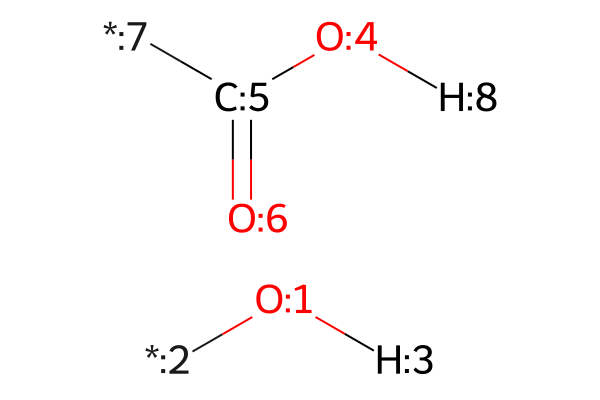

amide {1: (3, 6), 5: (6, 3)}


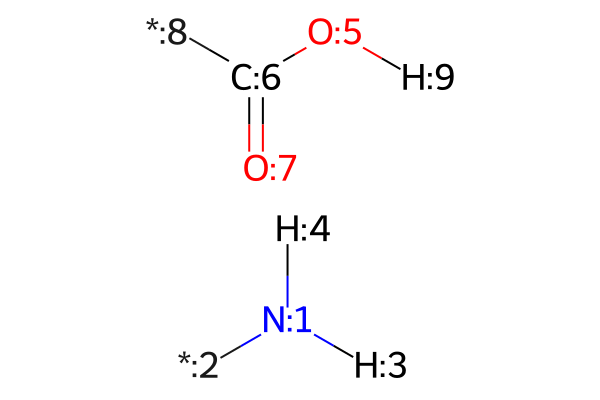

imide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


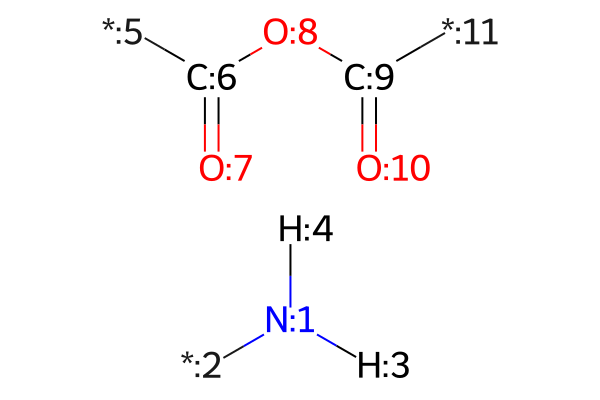

carbonate_phosgene {1: (3, 5), 4: (5, 3)}


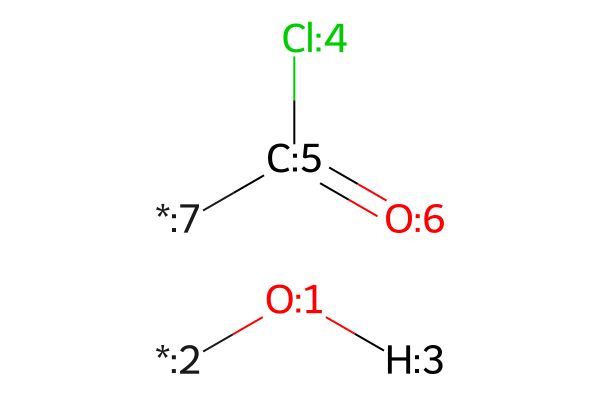

urethane {7: (5, 3), 2: (3, 5)}


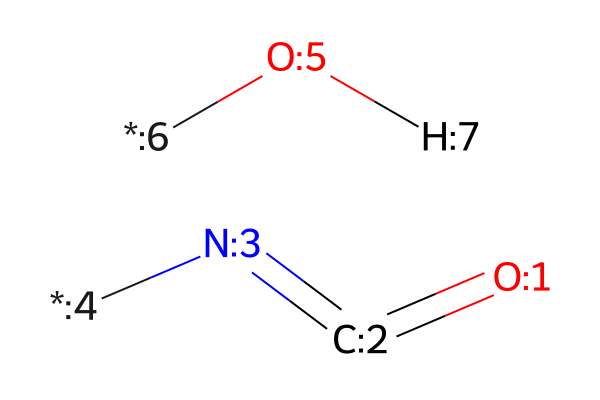

NIPU {5: (4, 13), 11: (13, 4)}


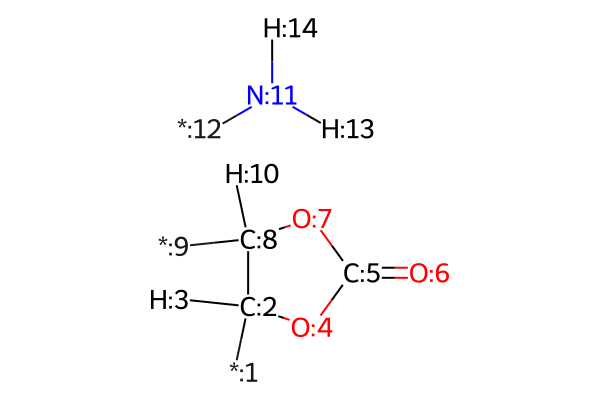

vinyl {1: (2, 8), 10: (8, 2)}


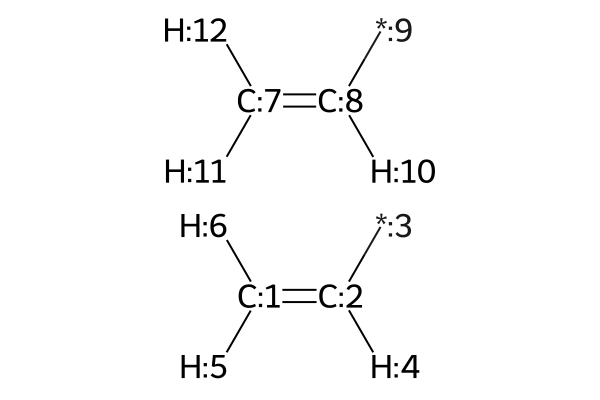

In [7]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

ester


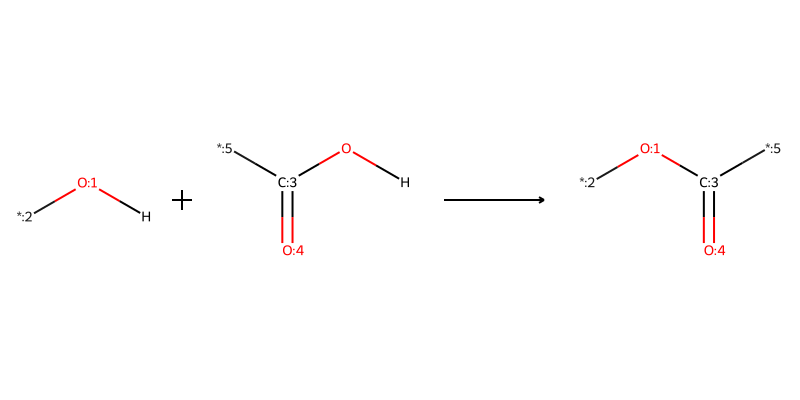

amide


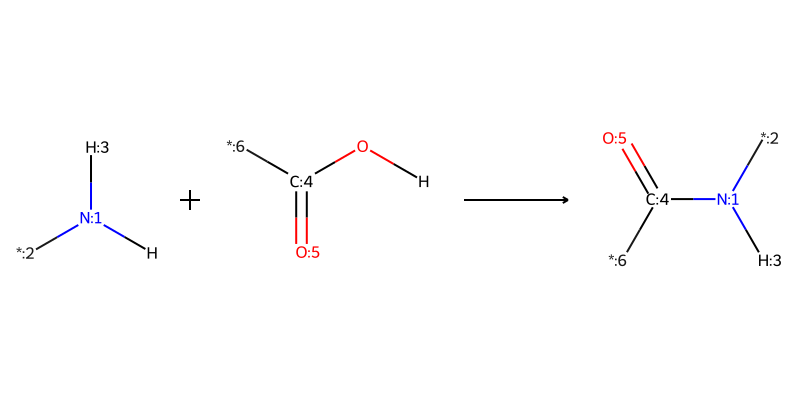

imide


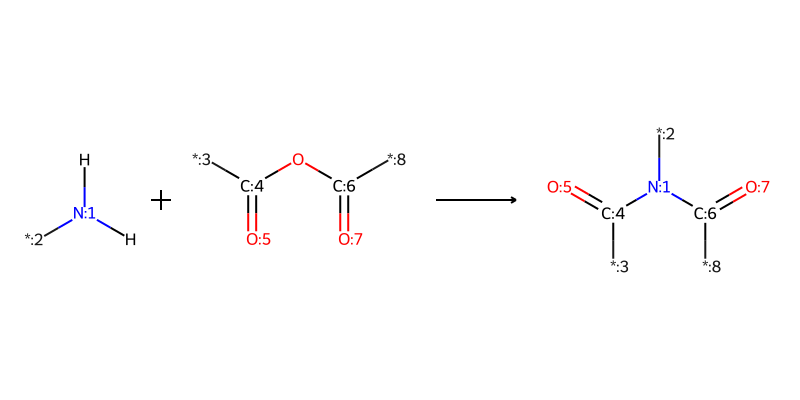

carbonate_phosgene


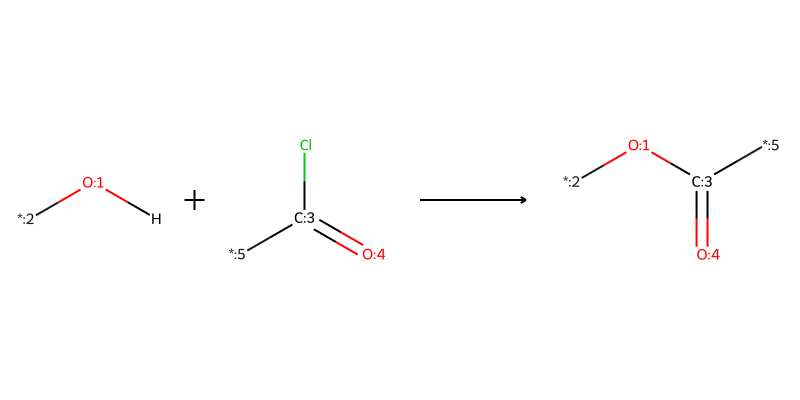

urethane


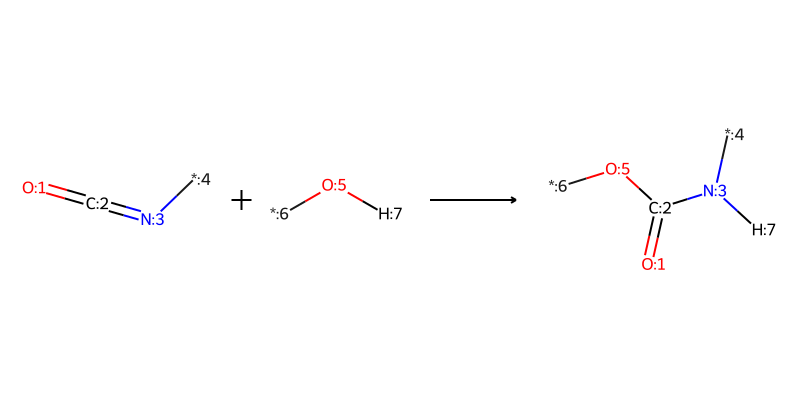

NIPU


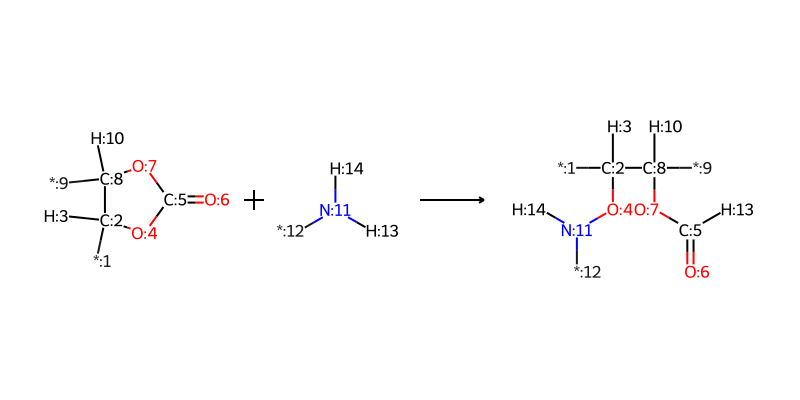

vinyl


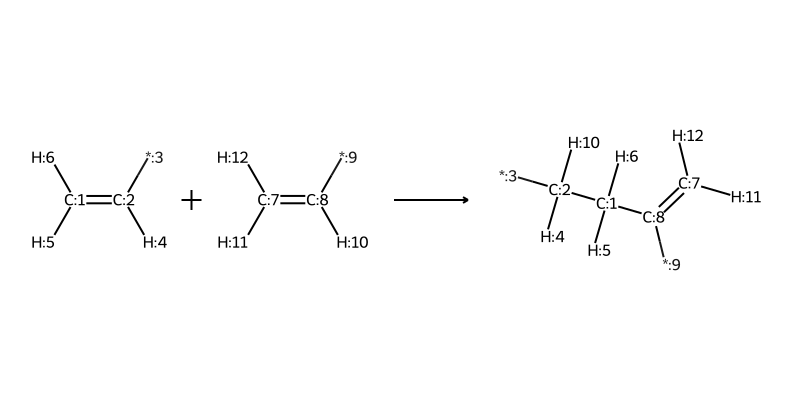

In [8]:
rxns, rxn_smarts = {}, {}
for mech_name, mech_schema in mechanisms.items():
    print(mech_name)
    rxn = mech_schema.get_rxn(debug_display=False)
    display(rxn)

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [9]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')

# Testing that reaction actually behave as intended

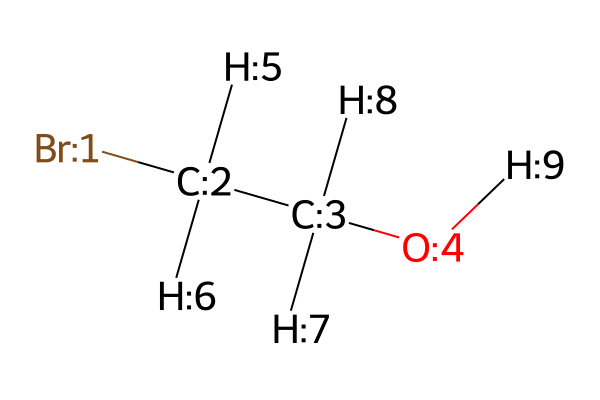

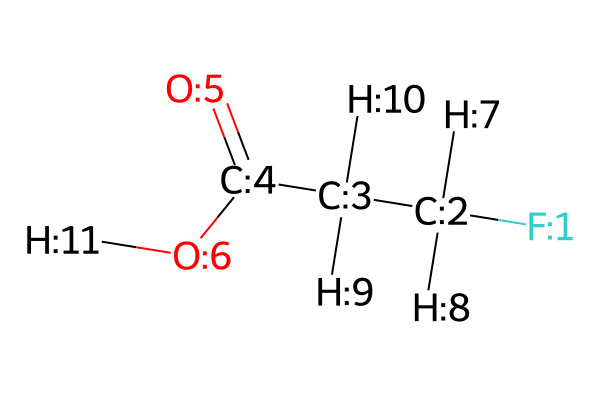

In [18]:
# smiles = ('C=C(CF)', 'C=C(CF)')
smiles = ('BrCCO', 'FCCC(=O)O')
          
reactants = []        
for sm in smiles:
    exp_smiles = specification.expanded_SMILES(sm)
    reactant = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    display(reactant)
    reactants.append(reactant)

0 0


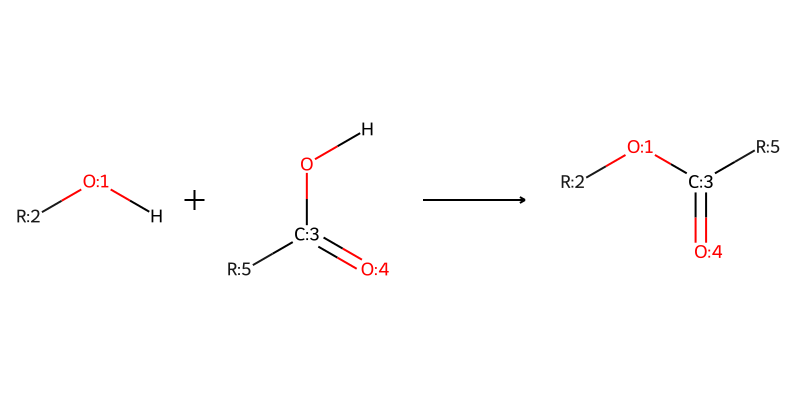

In [19]:
rxn = reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / 'ester.rxn')
rxn.Initialize()
num_warnings, num_errors = rxn.Validate()

print(num_warnings, num_errors)
display(rxn)

# Debug

In [ ]:
mech = mechanisms['amine']

reactants = mech.reactants
for atom in reactants.GetAtoms():
    atom.SetIntProp('molRxnRole', 1)
    # atom.SetProp('molFileAlias'   , 'reacali')
    # atom.SetProp('molFileValue'   , 'reac')
    # atom.SetProp('molRxnComponent', 'reaccomp')
    if atom.GetAtomicNum() == 0:
        pass


products = mech.products()
for atom in products.GetAtoms():
    atom.SetIntProp('molRxnRole', 2)
    # atom.SetProp('molFileAlias'   , 'prodali')
    # atom.SetProp('molFileValue'   , 'prod')
    # atom.SetProp('molRxnComponent', 'prodcomp')
    if atom.GetAtomicNum() == 0:
        pass


m = Chem.CombineMols(reactants, products)
rdDepictor.Compute2DCoords(m)
display(m)

r = rdChemReactions.ReactionFromMolecule(m)
block = rdChemReactions.ReactionToRxnBlock(r)
with Path('new.rxn').open('w') as file:
    file.write(block)

print(block)
rdChemReactions.PreprocessReaction(r)

# Reverse-engineering example reactions from RDKit

(((1, 'azide'),), ((1, 'carboxylicacid,acidchloride'),))


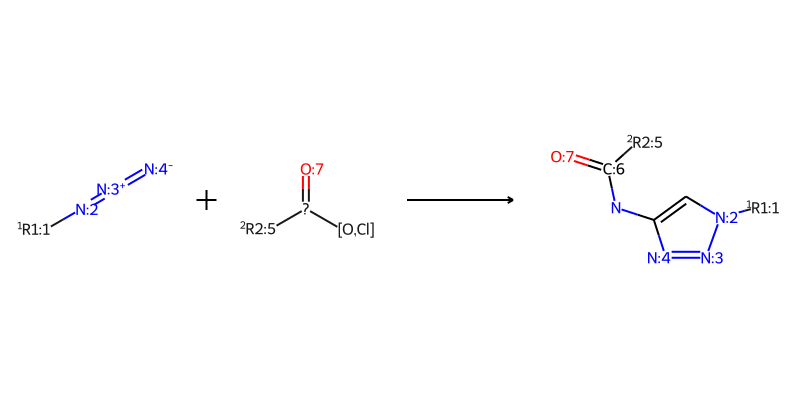

In [24]:
# rxn = rdChemReactions.ReactionFromRxnFile('test.rxn')
rxn = rdChemReactions.ReactionFromRxnFile('azide.rxn')
nWarn,nError,nReacts,nProds,reactantLabels = rdChemReactions.PreprocessReaction(rxn)
print(reactantLabels)
display(rxn)

[*:5]-[#6;$(C(=O)[O;H1,-]),$(C(=O)Cl):6](-[#8,#17])=[#8:7]


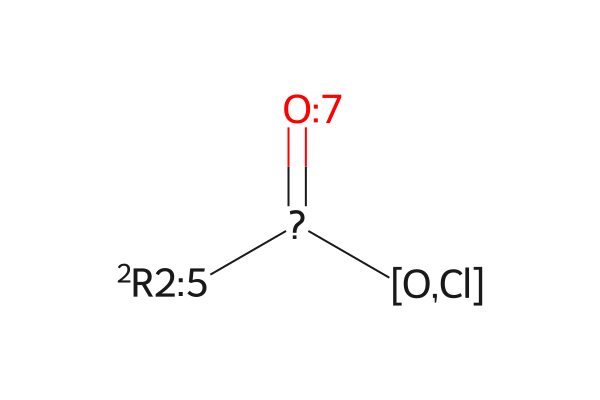

{1: 'carboxylicacid,acidchloride'}

In [25]:
from polymerist.rdutils import rdprops

r1 = rxn.GetReactantTemplate(1)
print(Chem.MolToSmarts(r1))
display(r1)


rdprops.aggregate_atom_prop(r1, 'molFileValue', prop_type=str)